# DEEP LEARNING 

# Partie sur les images

- Reprise du Transfert learning (modèle VGG16 qui avait un score de plus de 0.4 pour un échantillon total réduit de 30000 observations) 
- Introduction de la pondération des classes
- Introduction des callbacks
- Optimisation bayésienne des hyperparamètres (en cours très long, sur tout l'échantillon)

### Objectif à dépasser : weighted F1-score = 0.5534 (Resnet)
Environnement : Project

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import glob, os
os.chdir('C:\\Users\\barry\\OneDrive - CSTBGroup\\image_ds\\images')

Optimisation bayésienne : 

!pip3 install GPy
!pip3 install GPyOpt
#!pip3 install flatbuffers
#NB PYTHON VERSION 3.6

print(tensorflow.__version__)
print(K.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(GPy.__version__)
print(GPyOpt.__version__)

In [2]:
# Install GPy, GPyOpt
import tensorflow 
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Récupérer les données:

In [3]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0)

Liste des images:

In [4]:
os.chdir('C:\\Users\\barry\\OneDrive - CSTBGroup\\image_ds')

In [5]:
import os #Miscellaneous operating system interfaces
#https://docs.python.org/3/library/os.html

#get current working directory
current_path = os.getcwd() 

#Training images path
images_path = current_path + r'/images/image_train/'

#List with the name of all training images
images_list = os.listdir(images_path)

Géneration nom des images:

In [6]:
#Create a column with the name of the picture
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image name']

0        image_1263597046_product_3804725264.jpg
1         image_1008141237_product_436067568.jpg
2          image_938777978_product_201115110.jpg
3           image_457047496_product_50418756.jpg
4         image_1077757786_product_278535884.jpg
                          ...                   
84911      image_941495734_product_206719094.jpg
84912    image_1188462883_product_3065095706.jpg
84913     image_1009325617_product_440707564.jpg
84914    image_1267353403_product_3942400296.jpg
84915       image_684671297_product_57203227.jpg
Name: image name, Length: 84916, dtype: object

### Répartition des images dans les échantillons train, validation et test

Répartion :

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)

X_val = X_train.iloc[:2400,:]
y_val = y_train.iloc[:2400,:]

X_train = X_train.iloc[:21600,:]
y_train = y_train.iloc[:21600:,:]

X_test = X_test.iloc[:6000,:]
y_test = y_test.iloc[:6000,:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)

X_val = X_train.iloc[:400,:]
y_val = y_train.iloc[:400,:]

X_train = X_train.iloc[:1600,:]
y_train = y_train.iloc[:1600:,:]

X_test = X_test.iloc[:600,:]
y_test = y_test.iloc[:600,:]

Qualité de la répartition :

In [8]:
trainy = pd.DataFrame(y_train.value_counts(), columns = ['Nombre_images_train'])
testy = pd.DataFrame(y_test.value_counts(), columns = ['Nombre_images_test'])
train_test = trainy.merge(testy, right_index = True, left_index = True)
train_test['y'] = train_test.index
yval = []
for i in train_test['y']:
    yval.append(i[0])
train_test['y'] = yval
train_test

,Nombre_images_train,Nombre_images_test,y
prdtypecode,,,
2583,6566,2045,2583
1560,3285,967,1560
2522,3236,993,2522
1300,3218,1006,1300
2060,3151,1060,2060
1280,3117,944,1280
2403,3033,979,2403
2280,3013,964,2280
1920,2729,866,1920


Téléchargement Tensorboad

In [9]:
%load_ext tensorboard

# TRANSFER LEARNING

In [10]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input,  # data augmentation
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )

val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

Using TensorFlow backend.


In [11]:
X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [12]:
batch_size = 32
path = os.chdir('C:\\Users\\barry\\OneDrive - CSTBGroup\\image_ds\\images\\image_train')
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)


val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

Found 54345 validated image filenames belonging to 27 classes.
Found 13587 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam                                                                  
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16

n_class = 27
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

#model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer=Adam(lr = 0.0001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [13]:
import keras as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam                                                                  
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import callbacks
# Remarque : manque le callback TensorBoard

def build_model( learning_rate = 1e-4, rate = 0.2, units_1 = 1024 , units_2 = 512) :
# Modèle VGG16
    base_model = VGG16(weights='imagenet', include_top=False) 
# Freezer les couches du VGG16
    for layer in base_model.layers: 
        layer.trainable = False
    model = Sequential()
    model.add(base_model) # Ajout du modèle VGG16
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(units_1,activation='relu'))
    model.add(Dropout(rate=rate))
    model.add(Dense(units_2, activation='relu'))
    model.add(Dropout(rate=rate))
    model.add(Dense(27, activation='softmax'))
    model.compile(optimizer=Adam(lr = learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])

    lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
    early_stop = callbacks.EarlyStopping(monitor='val_acc',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
    
    checkpoint = callbacks.ModelCheckpoint('vgg16_60_20_20_3hyp.h5',
                                           monitor='val_acc',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
    return model, lr_reduce, early_stop, checkpoint

In [14]:
import sklearn
from sklearn.utils import class_weight

def fit_model(model, lr_reduce, early_stop, checkpoint):
    """function that trains the head classifier"""
    class_weights = class_weight.compute_class_weight('balanced',
                                                      np.unique(train_generator.classes),  train_generator.classes)
    train_class_weights = dict(enumerate(class_weights))

    history = model.fit_generator(generator=train_generator, 
                                epochs = 2,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data = val_generator,
                                validation_steps = len(X_val)//batch_size, 
                               class_weight = train_class_weights,
                           callbacks =  [lr_reduce, early_stop, checkpoint]
                                )
    return history

In [15]:
from sklearn.metrics import f1_score

def evaluate_model(model):
    y_tl_pred_2 = model.predict_generator(test_generator, verbose = 1)
    y_tl_pred_2 = y_tl_pred_2.argmax(axis = 1)
    evaluation = f1_score(test_generator.classes, y_tl_pred_2 , average = "weighted")
    return evaluation

In [16]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
#kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)

# hyperparameter bounds
bounds = [{'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3,1e-4, 1e-5)},
           {'name': 'rate', 'type': 'discrete', 'domain': (0.2, 0.3,0.4,0.5)},
         {'name': 'units_1', 'type': 'discrete', 'domain': ( 128, 256, 512,1024)},
         {'name': 'units_2', 'type': 'discrete', 'domain': (64, 128, 256,512)}]


# objective function for the model optimization:
def f(x):
    print()
    print("Hyperparameters:", x)
    # Retrieve 'accuracy' from the previously saved model
    try:
        previous_best_model = models.load_model('vgg16_60_20_20_3hyp_best.h5')
        previous_evaluation = evaluate_model(previous_best_model)
    except Exception:
        previous_best_model = None
        
    model, lr_reduce, early_stop, checkpoint = build_model(
                                        learning_rate=float(x[:,0]),
                                        rate=float(x[:,1]),
                                        units_1=int(x[:,1]),
                                        units_2=int(x[:,1]))
    history = fit_model(model, lr_reduce, early_stop, checkpoint)
    evaluation = evaluate_model(model)
    print()
    print("F1_score:\t{0}".format(evaluation))
    print(evaluation)
    print()
    # compare previous and current validation accuracies
    if not previous_best_model:
        keras.models.save_model(model, 'vgg16_60_20_20_3hyp_best.h5', overwrite=False,include_optimizer=True)
    if previous_best_model and evaluation > previous_evaluation:
        keras.models.save_model(model, 'vgg16_60_20_20_3hyp_best.h5', overwrite=True, include_optimizer=True)
    # Get the dictionary containing each metric and the loss for each epoch
    # history_dict = history.history
    # print(history_dict)
    def plot_history(history):
        """function that plots the model loss and accuracy"""
        plt.figure(1, figsize = (15,8))
        plt.subplot(221)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'])
        
        plt.subplot(222)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'])  
        plt.show()
     # plot the model accuracy and loss results
    plot_history(history)
    # delete the instantiated models from memory and clear the session
    del model
    del previous_best_model
    keras.backend.clear_session()
    return evaluation  



Optimisation Bayésienne (en cours) :


Hyperparameters: [[1.00e-03 2.00e-01 5.12e+02 5.12e+02]]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2
1698/1698 [==============================] - 5411s 3s/step - loss: 3.2963 - acc: 0.0372 - val_loss: 3.2958 - val_acc: 0.0365

Epoch 00001: val_acc improved from -inf to 0.03648, saving model to vgg16_60_20_20_3hyp.h5
Epoch 2/2
1698/1698 [==============================] - 5407s 3s/step - loss: 3.2955 - acc: 0.0372 - val_loss: 3.2958 - val_acc: 0.0365

Epoch 00002: val_acc did not improve from 0.03648
531/531 [==============================] - 6848s 13s/step

F1_score:	0.0024187812081845647
0.0024187812081845647



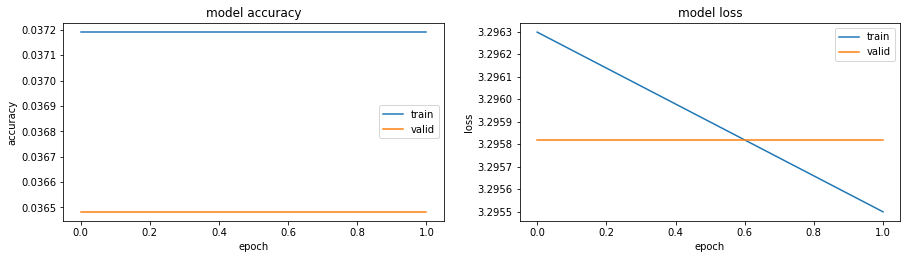


Hyperparameters: [[1.00e-04 3.00e-01 1.28e+02 2.56e+02]]
Epoch 1/2
1698/1698 [==============================] - 5397s 3s/step - loss: 3.2959 - acc: 0.0372 - val_loss: 3.2958 - val_acc: 0.0364

Epoch 00001: val_acc improved from -inf to 0.03641, saving model to vgg16_60_20_20_3hyp.h5
Epoch 2/2
1266/1698 [=====================>........] - ETA: 18:43 - loss: 3.2982 - acc: 0.0364

In [ ]:
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                random_state=1)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=10, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('optimisation_VGG16.txt')

Paramètres optimisés : 

In [ ]:
# print optimized model
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[4]["name"], optimizer.x_opt[3]))
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))

Téléchargement du meilleur modèle : 

In [ ]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('cifar10_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

In [18]:
%tensorboard --logdir logs2

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 20236.

Nombre couches à defreezed : 

In [31]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tl_2_defreeze = model.fit_generator(generator=train_generator, 
                                epochs = 10,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size, 
                                    class_weight=class_weights
                                )

In [ ]:
y_tl_pred_2 = model.predict_generator(test_generator, verbose = 1)
y_tl_pred_2 = y_tl_pred_2.argmax(axis = 1)

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_generator.classes, y_tl_pred_2 , average = "weighted")

In [ ]:
print("Score initiale : 0.44")

Graph : 

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc,  label = "Entrainement")
plt.plot(epochs, val_acc,  label= "Validation")
plt.title("Exactitude pendant l'\entraînement et la validation")
plt.legend()
          
plt.figure()
          
plt.plot(epochs, loss, label = 'Entrainement')
plt.plot(epochs, val_loss, 'b', label = "Validation")
plt.title("Perte pendant l'\entraînement et la validation")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
print(pd.DataFrame(confusion_matrix( test_generator.classes, y_tl_pred_2)))